In [2]:
import math
import torch
import numpy as np
from matplotlib import pyplot as plt

from matplotlib import style
style.use('seaborn-white')

/tmp/ipykernel_2012144/2461956534.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn-white')


In [2]:
def cartPoleDyn(theta, theta_d, x, x_d, m1, m2, length, k_inertia, mu_c, mu_p, gravity, force, dt):
    theta_dd = ((m1+m2)*gravity*np.sin(theta)-np.cos(theta)*(force+m2*length*(theta_d**2)*np.sin(theta)-mu_c*x_d)-((m1+m2)*mu_p*theta_d)/(m2*length)) / ((m1+m2)*(k_inertia+1)*length - m2*length*(np.cos(theta))**2)
    x_dd = (force-m2*length*(theta_dd*np.cos(theta)-(theta_d**2)*np.sin(theta))-mu_c*x_d) / (m1+m2)
    # Euler Integrator 
    x_d = x_d + x_dd*dt
    x = x + x_d*dt
    theta_d = theta_d + theta_dd*dt
    theta = theta + theta_d*dt
    return theta_dd, theta_d, theta, x_dd, x_d,  x 

In [56]:
np.mod(6.32, 2*np.pi) - np.mod(6.24, 2*np.pi)
np.linspace(500,510,num=1001)

array([500.00, 500.01, 500.02, ..., 509.98, 509.99, 510.00])

In [40]:
# Uncertainty Sources 
m1 = 1 
m2 = 0.1
length = 0.5
k_inertia = 1/3
#mu_c = float(np.random.uniform(0.0005, 2, 1))
#mu_c = max(0, float(np.random.normal(0.0005, 1, 1)))
mu_c = 0.0005
mu_c_noisy = 0.0005+0.2
#mu_p = float(np.random.uniform(0.000002, 2, 1))             # Uniform noise
# mu_p = max(0, float(np.random.normal(0.000002, 1, 1)))      # Gaussian Noise
mu_p = 0.000002
mu_p_noisy = 0.000002+0.2
gravity = 9.8                                               
dt = 0.01

# Initialization 
theta = 0.3 # np.random.uniform(low=-0.05, high=0.05)
theta_d = 1 # np.random.uniform(low=-0.05, high=0.05)
x = 0 # np.random.uniform(low=-0.05, high=0.05)
x_d = 0 # np.random.uniform(low=-0.05, high=0.05)

# lists for storing results 
theta_dd_sim = []
theta_d_sim = [theta_d]
theta_sim = [theta]
x_dd_sim = []
x_d_sim = [x_d]
x_sim = [x]

noOfSteps = 200000 #200000 # 12000
ts = np.linspace(0, noOfSteps/(1/dt), num=noOfSteps, endpoint=False)

for i in range(noOfSteps):
    force = -0.2+0.5*np.sin(6*ts[i])
    #force = -1+np.sin(ts[i])+3*np.sin(2*ts[i])
    #force = -0.5+0.2*np.sin(ts[i])+0.3*np.sin(2*ts[i])
    if i<199000: # 190000 # 11300
        theta_dd, theta_d, theta, x_dd, x_d, x = cartPoleDyn(theta, theta_d, x, x_d, m1, m2, length, k_inertia, mu_c, mu_p, gravity, force, dt)
    else:
        theta_dd, theta_d, theta, x_dd, x_d, x = cartPoleDyn(theta, theta_d, x, x_d, m1, m2, length, k_inertia, mu_c_noisy, mu_p_noisy, gravity, force, dt)
    theta_dd_sim.append(theta_dd)
    theta_d_sim.append(theta_d)
    theta_sim.append(theta)
    x_dd_sim.append(x_dd)
    x_d_sim.append(x_d)
    x_sim.append(x)

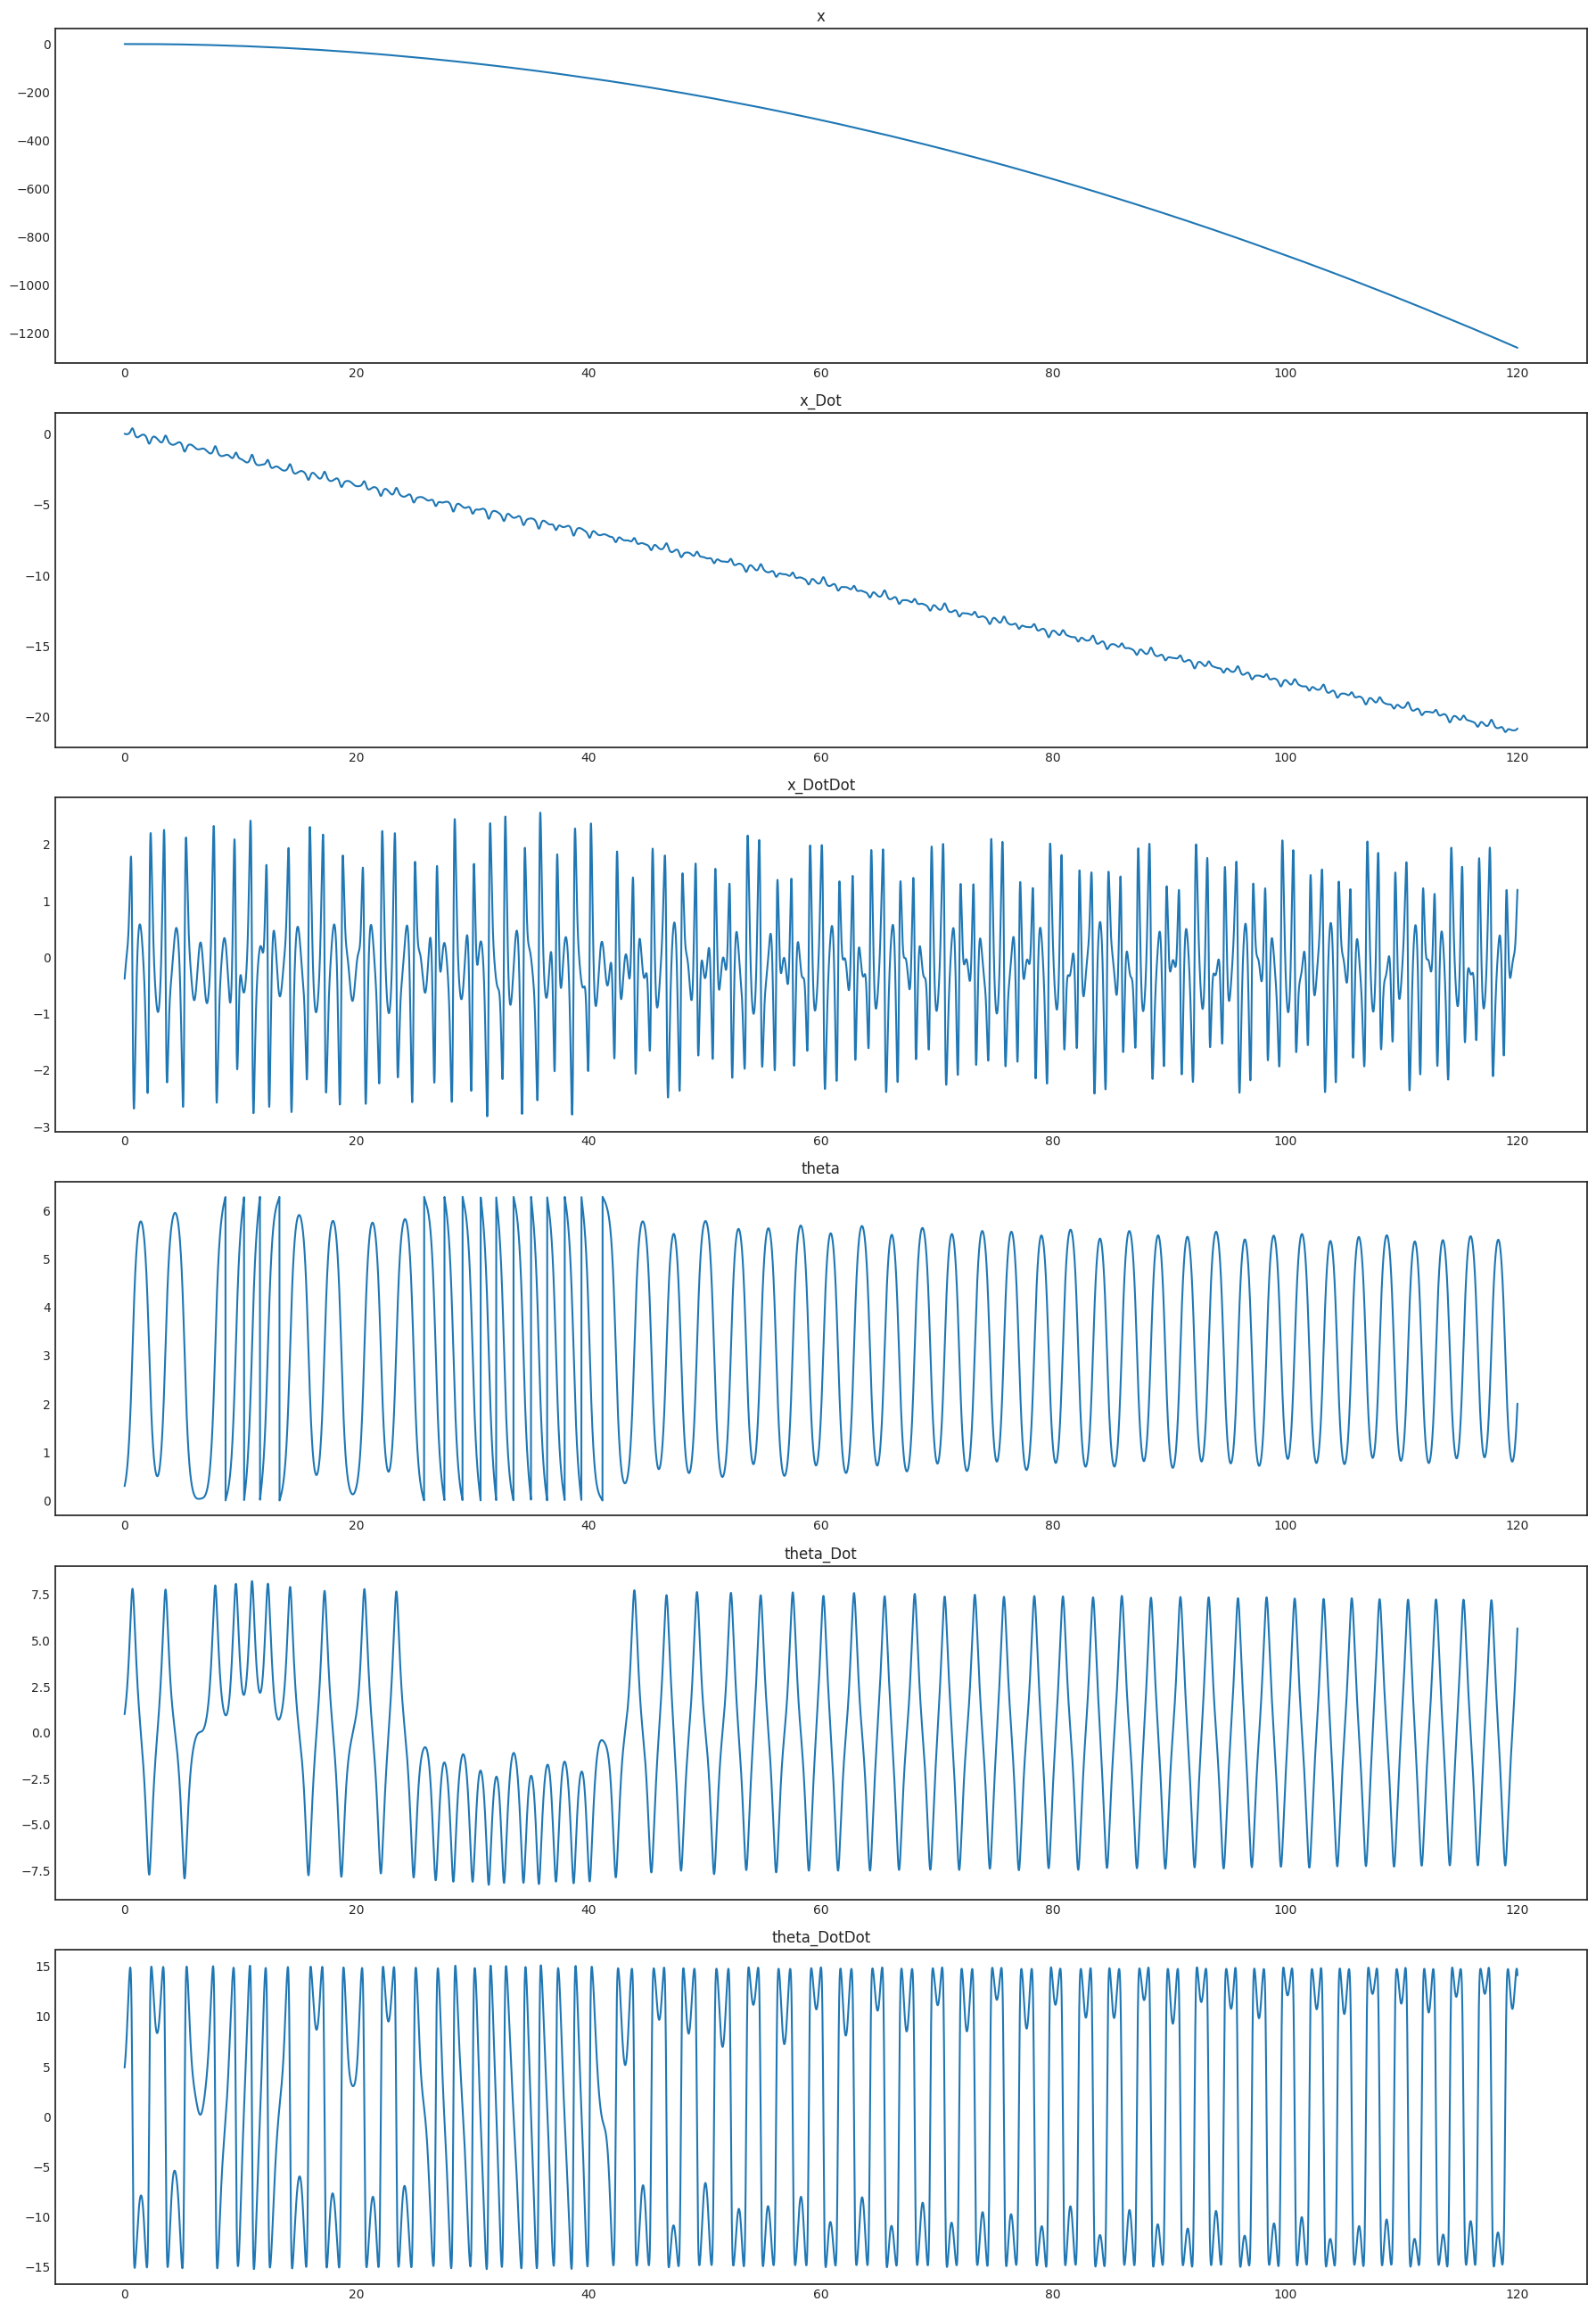

In [41]:
# Converting to Numpy Arrays for Plotting
theta_dd_sim = np.array(theta_dd_sim)
theta_d_sim = np.array(theta_d_sim)
theta_sim = np.array(theta_sim)
x_dd_sim = np.array(x_dd_sim)
x_d_sim = np.array(x_d_sim)
x_sim = np.array(x_sim)

#theta_sim = np.mod(theta_sim, 2*np.pi) 
#theta_sim = (theta_sim - np.mean(theta_sim)) / np.std(theta_sim) 

timeSteps = np.linspace(0, noOfSteps/(1/dt), num=noOfSteps, endpoint=False)

startTraj = 0
endTraj = 12000

# Plotting 
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6)

fig.set_figheight(26)
fig.set_figwidth(18)

ax1.plot(timeSteps[startTraj:endTraj], x_sim[startTraj:endTraj])
ax1.set_title("x")
ax2.plot(timeSteps[startTraj:endTraj], x_d_sim[startTraj:endTraj])
ax2.set_title("x_Dot")
ax3.plot(timeSteps[startTraj:endTraj], x_dd_sim[startTraj:endTraj])
ax3.set_title("x_DotDot")
#axs[1, 0].sharex(axs[0, 0])
ax4.plot(timeSteps[startTraj:endTraj], theta_sim[startTraj:endTraj])
ax4.set_title("theta")
ax5.plot(timeSteps[startTraj:endTraj], theta_d_sim[startTraj:endTraj])
ax5.set_title("theta_Dot")
ax6.plot(timeSteps[startTraj:endTraj], theta_dd_sim[startTraj:endTraj])
ax6.set_title("theta_DotDot")
fig.tight_layout()

Text(0.5, 1.0, 'A single plot')

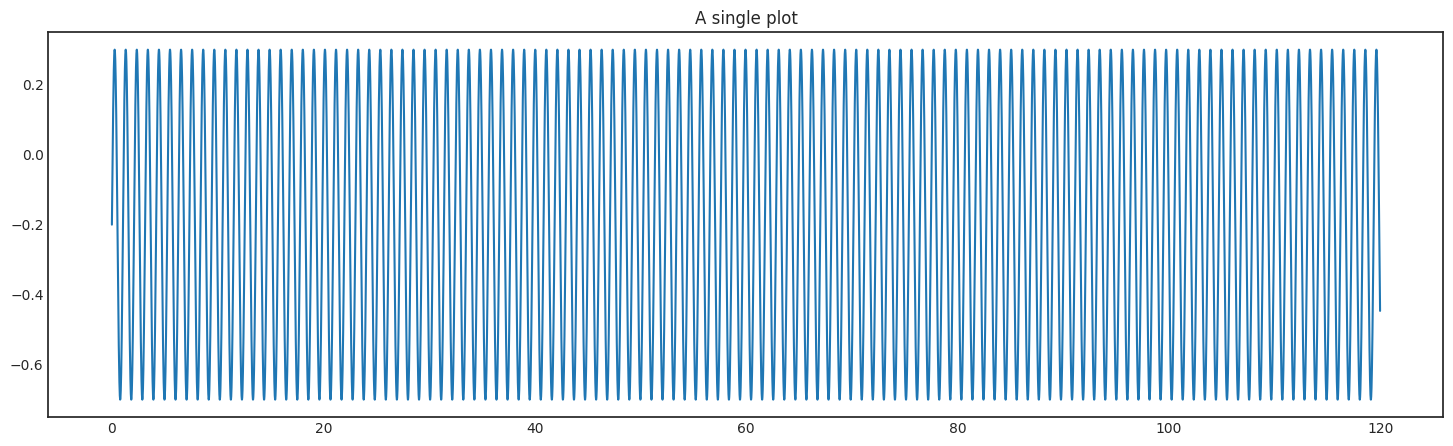

In [5]:
# Force Input Plot 
forceIn = -0.2+0.5*np.sin(6*timeSteps)
fig, ax = plt.subplots()

fig.set_figheight(5)
fig.set_figwidth(18)

ax.plot(timeSteps[startTraj:endTraj], forceIn[startTraj:endTraj])
ax.set_title('A single plot')

# Adding noise

In [6]:
# I AM NOT ADDING ANY NOISE TO THE OUTPUTS THETA DOUBLE DOT AND X DOUBLE DOT 
SEED = 0
np.random.seed(SEED)
loc = 0
theta_sim_noisy = theta_sim + np.random.normal(loc=loc, scale=0.1, size=theta_sim.shape)
theta_d_sim_noisy = theta_d_sim + np.random.normal(loc=loc, scale=0.2, size=theta_d_sim.shape)
x_sim_noisy = x_sim + np.random.normal(loc=loc, scale=0.003, size=x_sim.shape)
x_d_sim_noisy = x_d_sim + np.random.normal(loc=loc, scale=0.01, size=x_d_sim.shape)
#forceIn_noisy = forceIn + np.random.normal(loc=loc, scale=0.2, size=forceIn.shape)
#forceIn_noisy = forceIn

# Noisy input data

In [7]:
allData = np.stack((theta_sim_noisy[:-1], theta_d_sim_noisy[:-1], x_sim_noisy[:-1], x_d_sim_noisy[:-1], forceIn, theta_dd_sim, x_dd_sim), axis=1)
#np.savetxt('../noisyCase/noisyInputBigData.csv', allData, delimiter=',')

# saving data 

In [8]:
allData = np.stack((theta_sim[:-1], theta_d_sim[:-1], x_sim[:-1], x_d_sim[:-1], forceIn, theta_dd_sim, x_dd_sim), axis=1)
#np.savetxt('../noisyCase/noisyBigData.csv', allData, delimiter=',')

# Plotting noisy vs original 

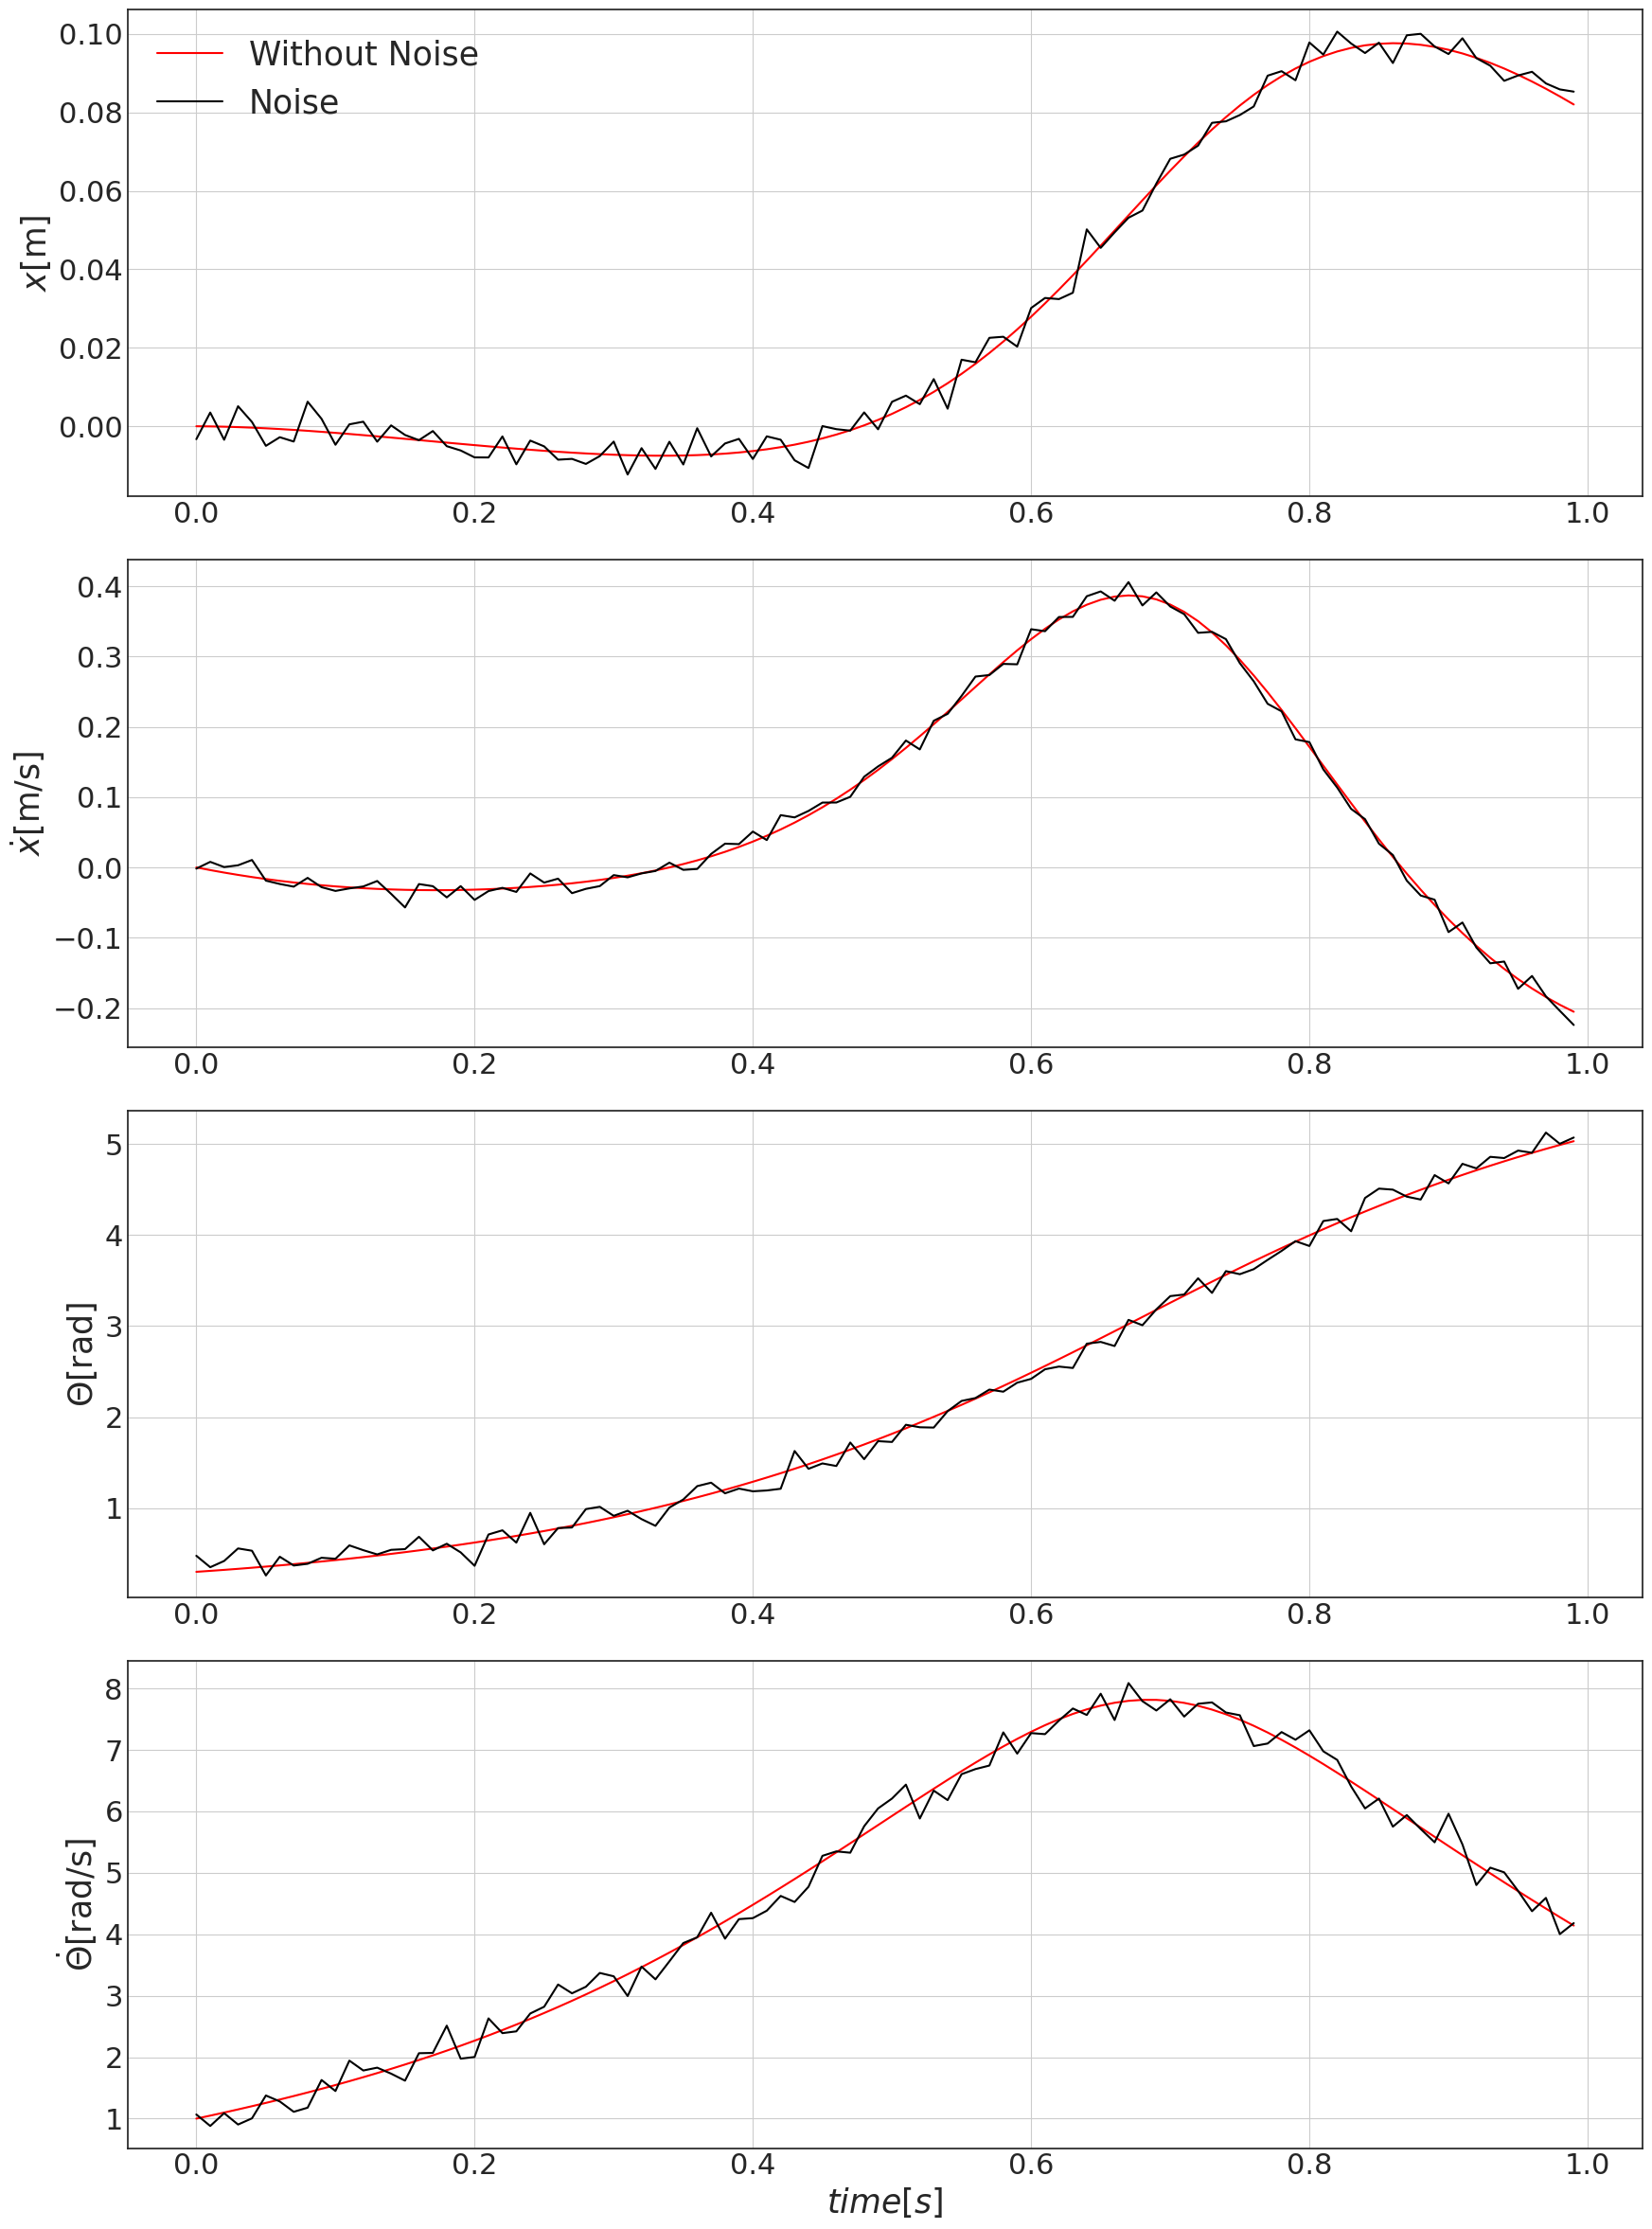

In [10]:
# Converting to Numpy Arrays for Plotting

timeSteps = np.linspace(0, noOfSteps/(1/dt), num=noOfSteps, endpoint=False)

startTraj = 0
endTraj = startTraj + 100

# Plotting 
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4)

fig.set_figheight(24)
fig.set_figwidth(18)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=22)     # fontsize of the axes title
plt.rc('axes', labelsize=25)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=22)    # fontsize of the tick labels
plt.rc('ytick', labelsize=22)    # fontsize of the tick labels
plt.rc('legend', fontsize=25)    # legend fontsize
plt.rc('figure', titlesize=12)  # fontsize of the figure title

ax1.plot(timeSteps[startTraj:endTraj], x_sim[startTraj:endTraj], "r")
ax1.plot(timeSteps[startTraj:endTraj], x_sim_noisy[startTraj:endTraj], "k")
ax1.set_ylabel(r"$x$[m]")
ax1.legend(('Without Noise', 'Noise'))
ax1.grid(True)
ax2.plot(timeSteps[startTraj:endTraj], x_d_sim[startTraj:endTraj], "r")
ax2.plot(timeSteps[startTraj:endTraj], x_d_sim_noisy[startTraj:endTraj], "k")
ax2.set_ylabel(r"$\dot{x}$[m/s]")
ax2.grid(True)
#ax3.plot(timeSteps[startTraj:endTraj], x_dd_sim[startTraj:endTraj], "r")
#ax3.set_title("x_DotDot")
#ax3.grid(True)
#axs[1, 0].sharex(axs[0, 0])
ax3.plot(timeSteps[startTraj:endTraj], theta_sim[startTraj:endTraj], "r")
ax3.plot(timeSteps[startTraj:endTraj], theta_sim_noisy[startTraj:endTraj], "k")
ax3.set_ylabel(r"$\Theta$[rad]")
ax3.grid(True)
ax4.plot(timeSteps[startTraj:endTraj], theta_d_sim[startTraj:endTraj], "r")
ax4.plot(timeSteps[startTraj:endTraj], theta_d_sim_noisy[startTraj:endTraj], "k")
ax4.set_ylabel(r"$\dot{\Theta}$[rad/s]")
ax4.set_xlabel("$time[s]$")
ax4.grid(True)
#ax6.plot(timeSteps[startTraj:endTraj], theta_dd_sim[startTraj:endTraj])
#ax6.set_title("theta_DotDot")
#ax6.grid(True)
fig.tight_layout()
plt.savefig("./../../Results/deep_ensemble/noisy_features.png")

# Truncated Gaussian 

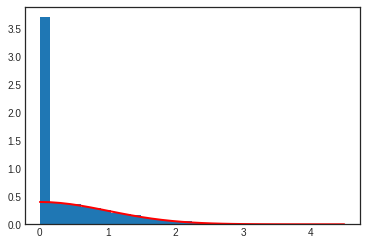

In [80]:
mu, sigma = 0.000002, 1  
rand_mu1 = np.fmax(0, np.random.normal(mu, sigma, 12000))
count, bins, ignored = plt.hist(rand_mu1, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.show()

# Log-normal

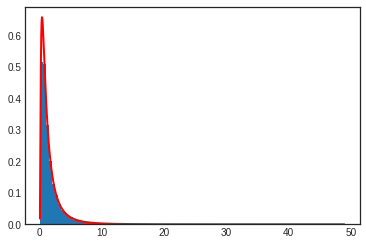

In [81]:
mu, sigma = 0.000002, 1  
rand_mu2 = np.random.lognormal(mu, sigma, 12000)
count, bins, ignored = plt.hist(rand_mu2, 100, density=True, align='mid')
x = np.linspace(min(bins), max(bins), 10000)
pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))
       / (x * sigma * np.sqrt(2 * np.pi)))
plt.plot(x, pdf, linewidth=2, color='r')
plt.axis('tight')
plt.show()

# Uniform 

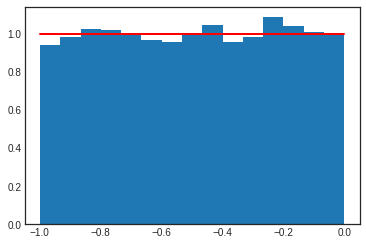

In [30]:
s = np.random.uniform(-1,0,12000)
count, bins, ignored = plt.hist(s, 15, density=True)
plt.plot(bins, np.ones_like(bins), linewidth=2, color='r')
plt.show()